In [24]:
import pandas as pd
from collections import defaultdict
import json
import krippendorff
import numpy as np
from scipy import stats
import seaborn as sns
import string
import re
import collections
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import random
import matplotlib.pyplot as plt
import matplotlib.colors
#import plotly.express as px
#import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm

In [4]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
    return results_df

def add_star(p):
    sig = ' '
    if p < 0.05:
        sig = '*'
    else:
        sig = ' '
    if p < 0.01:
        sig = '**'
    if p < 0.001:
        sig = '***'
   
    return sig

        
def plot_reg_results(df, nrows = 1, ncols = 1, figsize=(4, 2), xlabel='xlabel', labels = None, title='', filename=None):
    #df = df.sort_values('coeff')
    xs = df['coeff']
    norm = matplotlib.colors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    colors = np.array([(mapper.to_rgba(v)) for v in xs])
    en_len = int(len(df))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    #plt.title('Uncertainty in Fields')
    st = fig.suptitle("", fontsize=14)
    #sigg = fig.suptitle("Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1", fontsize=14)
    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        ax.axvline(x=0.00,color='black',linewidth=1.7,linestyle='-')
        ax.xaxis.grid(True)
        ax.yaxis.label.set_color('white')
        #ax.set_xticks([-0.5, 0.0, 0.5, 1,0])
        #ax.set_xlabel(r"%s ($\beta$ coef.)"%xlabel, fontsize=14)
        ax.set_xlabel(xlabel,fontsize=14)
        #ax.set_xticks([-0.04, -0.02, 0, 0.02, 0.04])
        #ax.set_title(r"%s"%(labels[i] if labels else dvs[i]), fontsize=14)
        s = en_len*i
        en = en_len*(i+1)
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            #plt.plot(x, y, 'o', color=color)
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        #ax.set_xticklabels([-0.04, -0.02, 0, 0.02, 0.04], fontsize=14)
        ax.set_yticklabels(list(df['term']), fontsize=14)

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
    #sigg.set_y(-0.12)
    fig.text(0.5, -0.17, s="%s"%title,ha='center',fontsize=14)
    fig.text(0.5, -0.18, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05",ha='center',fontsize=9)
    if filename:
        plt.savefig('../figures/%s.pdf'%filename, bbox_inches='tight')

In [5]:
labels = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree' , 'Strongly Agree']
label2score = {l:i for i,l in enumerate(labels)}
def convert_data(df, multirate_keys = set(['Readability and newsworthiness', 'Practical implications and controversy'])):
    return_dict = defaultdict(list)
    cols = list(df.columns)
    for i, row in df.iterrows():
        item = {}
        for key_label in cols:
            key = key_label.split(":::")
            if len(key) == 1:
                item[key[0]] = row[key_label]
            elif key[0] == 'span_annotation':
                item[key[0]] = eval(row[key_label])
            elif key[1]=='bad_text':
                item['bad_text'] = row[key_label]
            elif len(key) == 2:
                #print(key_label, row[key_label])
                if key[0] in multirate_keys:
                    if str(row[key_label]) == 'nan':
                        item[key_label] = np.nan
                    else:
                        item[key_label] = label2score[row[key_label]]
                else:
                    #print(str(row[key_label]))
                    if key[0] not in item:
                        item[key[0]] = None

                    elif str(row[key_label]) != 'nan':
                        item[key[0]] = row[key_label]
                
                #if key[0] not in item:
                #    item[key[0]] = None
                #if row[key_label] == True:
                #    if key[1][:5] == 'scale':
                #        item[key[0]] = int(key[1].split('_')[1])
                #    else:
                #        item[key[0]] = key[1]
            else:
                print('error key: ', key)
        for key in item:
            return_dict[key].append(item[key])
    for key in return_dict:
        print(key,len(return_dict))
    return pd.DataFrame(return_dict)

question2key = {
    "What is your gender?": "gender",
    "What is your age?": "age",
    "How do you describe your race or ethnicity (You may select more than one option)": "race",
    "What is your occupation?": "occupation",
    "What is your education level?": "education",
    "Consider you read this email from a colleague, how polite do you think it is?": "politeness",
}

def get_user_dict(ann_df):
    user_keys = set(ann_df['user'])
    user_dict = {}
    df = ann_df[ann_df.instance_id.str.contains('demographic_questions.html')]
    for i, row in df.iterrows():
        user_dict[row['user']] = {question2key[k] if k in question2key else k:v.split(':::')[-1] if type(v)==str else v for k,v in dict(row).items()}
    return user_dict

def attach_user_info(ann_df, user_dict, keys):
    for key in keys:
        ann_df[key] = [user_dict[user][key] if key in user_dict[user] else None for user in ann_df['user']]
    return ann_df

def edit_distance(str1, str2):
    # Create a table to store the edit distances for substrings
    m = len(str1)
    n = len(str2)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # Initialize the table
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Compute the edit distances for substrings
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1]) + 1

    # The edit distance between the two strings is stored in the bottom-right cell
    return dp[m][n]
def get_mean(s):
    '''
        Return the mean of a list of labels
        Input: a list of labels (can contain 'bad_text' or 'nan')
        Output: a float or None
    '''
    s = [int(it) for it in s if it!='bad_text' and str(it) != 'nan']
    return sum(s)/len(s) if len(s) > 0 else None

def split_half_corr(df, key='pure_scores', seeds = [0,1,2,3,4]):
    '''
        randomly split the labels into two groups and calculate the Pearson'r r between the two groups
        Input:
            df: the input annotation dataframe
            key: the column key to be analyzed (default to pure_scores)
        Return:
            a list of the split half correlation scores 
    '''
    p = []
    for seed in seeds:
        random.seed(seed)
        scores = [random.sample(it,len(it)) for it in df[key] if len(it) >= 4]
        sp1 = [get_mean(it[:int(len(it)/2)]) for it in scores]
        sp2 = [get_mean(it[int(len(it)/2):]) for it in scores]
        p.append(stats.pearsonr(sp1,sp2)[0])
        #print(p)
    return sum(p)/len(p)#, np.std(p)
        
def get_exp_df(ann_df):
    exp_dict = {}
    df = ann_df[ann_df.instance_id.str.contains('experience.html')]
    for i, row in df.iterrows():
        exp_dict[row['user']] = {question2key[k] if k in question2key else k:v.split(':::')[-1] if type(v)==str else v for k,v in dict(row).items()}
    exp_df = pd.DataFrame.from_records(list(exp_dict.values()))
    return exp_df

Text(0, 0.5, 'How satisfied do you feel about \n your experience participating our study?')

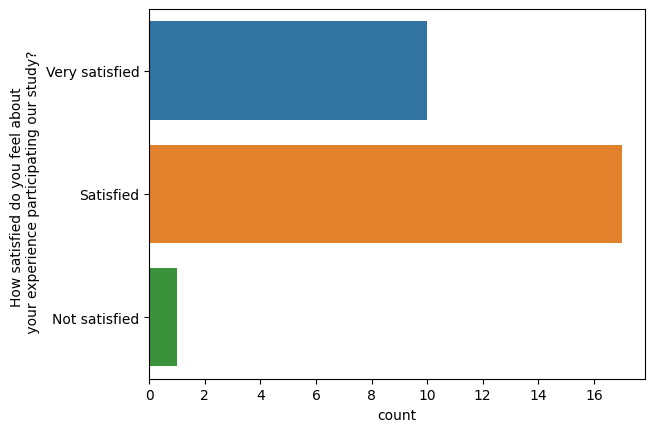

In [9]:
exp_df = get_exp_df(data_df)
ax = sns.countplot(y=exp_df['How satisfied do you feel about your experience participating our study?'],order=["Very satisfied", "Satisfied", "Not satisfied"])
#ax.set_yticklabels(["Very satisfied", "Satisfied", "Not satisfied"])
ax.set_ylabel('How satisfied do you feel about \n your experience participating our study?')

In [6]:

raw_df = pd.read_csv('data_files/news_pair_sample_100_pilot3.csv')
data_dict = {str(row['id']):dict(row) for i,row in raw_df.iterrows()}

In [7]:
data_df = pd.concat([
    pd.read_csv('annotation_output/pilots/pair_100/annotated_instances.tsv',sep='\t')
])
print(set(data_df['Please feel free to leave any comments about our study (optional):::text_box']))

{nan, "The first article appeared to be a companies promotional lierature rather then 'News'. There was no dat or evidenc presented or any indication it had been peer reviewed, just a lot of vague statements.", 'I loved the topics, and very interesting that I few I want to really know if true. ', 'Some of it required a lot of specific knowledge to appreciate I think.', 'I\'ve always liked reading scientific articles even if I didn\'t quite understand them. The one thing that jumped out at me was reading about the "organic" compounds in the meteorite. Interesting! So life on earth could have come with some primordial soup ingredient coming from somewhere else in the solar system. ', 'This is not a 5mins task!', 'very interesting study', 'A very good interesting study , and well presented.', 'Very different, interesting.', 'Thank you for letting me take part in your study. Some of those articles were a hard read for me as where I had no knowledge about the area alot of the words just wen

In [8]:
data_df = convert_data(data_df)
user_dict = get_user_dict(data_df)

user 28
instance_id 28
displayed_text 28
How satisfied do you feel about your experience participating our study? 28
How do you feel about your experience participating our study compared with other studies? 28
Readability and newsworthiness:::It tackles an important issue 28
Readability and newsworthiness:::It should be published in the news 28
Readability and newsworthiness:::It sounds interesting to me 28
Readability and newsworthiness:::I can understand it 28
Readability and newsworthiness:::It could be interesting to the general public 28
Readability and newsworthiness:::Understanding it requires domain knowledge 28
Readability and newsworthiness:::It is fun to read 28
Practical implications and controversy:::The presented information is overstated or exaggerated 28
Practical implications and controversy:::It could be controversial 28
Practical implications and controversy:::Knowing this finding could benefit a lot of people 28
Practical implications and controversy:::I learned so

In [9]:
ann_df = data_df[(~data_df.instance_id.str.contains('html'))&(data_df.user.isin(user_dict))]
ann_df = ann_df.rename(columns=question2key)
ann_df = attach_user_info(ann_df, user_dict, keys=['gender','race','age','education','How frequent do you read science news?'])

In [10]:
len(set(ann_df.user))

175

In [11]:
def get_agree_df(ann_df, column):
    a_df =  ann_df.rename(columns=question2key).pivot(index='instance_id', columns='user', values=column).sort_values('instance_id').reset_index()#[:-2]
    user_keys = list(set(ann_df['user']))
    p_dict = defaultdict(list)
    for i, row in a_df.iterrows():
        #print('Male',[row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Male'])
        #print('Female',[row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Female'])
        #male_s = 
        p_dict['scores'].append([it for it in row[user_keys] if str(it) != 'nan'])
        p_dict['users'].append([it for it in user_keys if str(row[it]) != 'nan'])
        #p_dict['male_intimacy'].append(get_mean([row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Male']))
        #p_dict['female_intimacy'].append(get_mean([row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Female']))
    for key in p_dict:
        a_df[key] = p_dict[key]
    #agree_df['r1'] = [it[0] for it in agree_df['scores']]
    #agree_df['r2'] = [it[1] if len(it) == 2 else '' for it in agree_df['scores']]

    #agree_df['scores'] = p_dict['scores']
    #for key in ['gender']:
    #    agree_df[key] = [[user_dict[it][key] for it in s] for s in p_dict['users']]
    a_df['scores_num'] = [len(s) for s in p_dict['scores']]
    #agree_df['scores_std'] = [np.std(s) for s in p_dict['scores']]
    a_df['label'] = [sum(s)/len(s) for s in p_dict['scores']]
    a_df.index = a_df.index.astype(str)
    return a_df

In [12]:
sel_cols

NameError: name 'sel_cols' is not defined

In [13]:
c_df = get_agree_df(t_df, 'Readability and newsworthiness:::I can understand it')
np.array(c_df[sel_users].replace(np.nan,np.nan)).transpose()
krippendorff.alpha(np.array(c_df[sel_users].replace(np.nan,np.nan)).transpose(), level_of_measurement='nominal')

NameError: name 't_df' is not defined

In [47]:
c_df

user,instance_id,scores,users,scores_num,label,dimension
0,http://ct.moreover.com/?a=34057330264&p=1pl&v=...,"[3.0, 2.0, 3.0, 4.0, 3.0]","[611b38dea7f1754225fa39bf, 5eecd2e3a38fd009dd9...",5,3.0,Practical implications and controversy:::Knowi...
1,http://ct.moreover.com/?a=34058570085&p=1pl&v=...,"[2.0, 2.0, 4.0, 3.0, 3.0]","[5ded5559033565416fe02a77, 60e492af9a22b6d8490...",5,2.8,Practical implications and controversy:::Knowi...
2,http://ct.moreover.com/?a=34084006303&p=1pl&v=...,"[0.0, 1.0, 2.0, 2.0, 2.0]","[5eecd2e3a38fd009dd9d1f3d, 60e276f5b3e7008e0a6...",5,1.4,Practical implications and controversy:::Knowi...
3,http://ct.moreover.com/?a=34124323674&p=1pl&v=...,"[3.0, 2.0, 3.0, 3.0, 1.0]","[5c3d4b92486a390001e87dfe, 5ddac93016d10ca2991...",5,2.4,Practical implications and controversy:::Knowi...
4,http://ct.moreover.com/?a=34565850608&p=1pl&v=...,"[2.0, 3.0, 1.0, 1.0, 3.0]","[5c3d4b92486a390001e87dfe, 5bae87fcf879c300013...",5,2.0,Practical implications and controversy:::Knowi...
...,...,...,...,...,...,...
60,https://animals.howstuffworks.com/insects/afri...,"[2.0, 2.0, 2.0, 2.0, 0.0]","[63207376461ca8b27f375473, 631745a70c7c585248d...",5,1.6,Practical implications and controversy:::Knowi...
61,https://www.futurity.org/gm-food-opinions-law-...,"[2.0, 2.0, 2.0, 3.0, 2.0]","[6108f72b081cf2b1cbde83aa, 631745a70c7c585248d...",5,2.2,Practical implications and controversy:::Knowi...
62,https://www.futurity.org/inducing-seizures-epi...,"[3.0, 3.0, 3.0, 4.0, 2.0]","[5ddac93016d10ca2991f7dbf, 595eaf865708720001a...",5,3.0,Practical implications and controversy:::Knowi...
63,https://www.futurity.org/safe-consumption-spac...,"[3.0, 3.0, 3.0, 3.0]","[5eecd2e3a38fd009dd9d1f3d, 60fd274decb79fba37f...",4,3.0,Practical implications and controversy:::Knowi...


In [15]:
sel_cols = ['Readability and newsworthiness:::It should be published in the news',
            'Readability and newsworthiness:::It tackles an important issue',
            'Readability and newsworthiness:::It is fun to read',
            'Readability and newsworthiness:::It could be interesting to the general public',
            'Readability and newsworthiness:::It sounds interesting to me',
            'Readability and newsworthiness:::I can understand it',
             'Readability and newsworthiness:::Understanding it requires domain knowledge',
 'Practical implications and controversy:::I learned something useful from it',
 'Practical implications and controversy:::Knowing this finding could benefit a lot of people',
 'Practical implications and controversy:::Knowing this finding could benefit a specific segment of the population',
 'Practical implications and controversy:::It could be controversial',
 'Practical implications and controversy:::The finding seems surprising to me',
 'Practical implications and controversy:::The presented information is overstated or exaggerated'           
 ]

In [81]:
agg_df

user,instance_id,scores,users,scores_num,label,dimension,Mention title,category,outlet,statement,FleschReadingEase
0,http://ct.moreover.com/?a=34057330264&p=1pl&v=...,"[2.0, 2.0, 3.0, 4.0, 2.0]","[611b38dea7f1754225fa39bf, 5eecd2e3a38fd009dd9...",5,2.60,Readability and newsworthiness:::It should be ...,Antarctic seals can help predict ice sheet melt,PressRelease,Science Daily,It should be published in the news,-79.300323
1,http://ct.moreover.com/?a=34058570085&p=1pl&v=...,"[3.0, 3.0, 4.0, 4.0, 2.0]","[5ded5559033565416fe02a77, 60e492af9a22b6d8490...",5,3.20,Readability and newsworthiness:::It should be ...,Seals help scientists study Antarctic ice shee...,General,UPI.com,It should be published in the news,-79.300323
2,http://ct.moreover.com/?a=34084006303&p=1pl&v=...,"[3.0, 2.0, 1.0, 2.0, 4.0]","[5eecd2e3a38fd009dd9d1f3d, 60e276f5b3e7008e0a6...",5,2.40,Readability and newsworthiness:::It should be ...,Matabele ants: Travelling faster with detours,PressRelease,Science Daily,It should be published in the news,-188.602143
3,http://ct.moreover.com/?a=34124323674&p=1pl&v=...,"[2.0, 2.0, 2.0, 3.0, 3.0]","[5c3d4b92486a390001e87dfe, 5ddac93016d10ca2991...",5,2.40,Readability and newsworthiness:::It should be ...,"Seals can be scientists, too",SciTech,Quartz,It should be published in the news,-79.300323
4,http://ct.moreover.com/?a=34565850608&p=1pl&v=...,"[2.0, 3.0, 2.0, 3.0, 2.0]","[5c3d4b92486a390001e87dfe, 5bae87fcf879c300013...",5,2.40,Readability and newsworthiness:::It should be ...,What is the meaning of life? Ask a conservativ...,PressRelease,Science Daily,It should be published in the news,-96.269441
...,...,...,...,...,...,...,...,...,...,...,...
60,https://animals.howstuffworks.com/insects/afri...,"[2.0, 1.0, 3.0, 3.0, 1.0]","[63207376461ca8b27f375473, 631745a70c7c585248d...",5,2.00,Practical implications and controversy:::The f...,African Ant GPS Finds Fastest Route Home,General,HowStuffWorks,The finding seems surprising to me,-188.602143
61,https://www.futurity.org/gm-food-opinions-law-...,"[1.0, 1.0, 3.0, 1.0, 3.0]","[6108f72b081cf2b1cbde83aa, 631745a70c7c585248d...",5,1.80,Practical implications and controversy:::The f...,People are still 'grossed out' by GM food,PressRelease,Futurity,The finding seems surprising to me,5.282759
62,https://www.futurity.org/inducing-seizures-epi...,"[2.0, 3.0, 1.0, 2.0, 2.0]","[5ddac93016d10ca2991f7dbf, 595eaf865708720001a...",5,2.00,Practical implications and controversy:::The f...,Inducing seizures can also pinpoint their origin,PressRelease,Futurity,The finding seems surprising to me,-369.883971
63,https://www.futurity.org/safe-consumption-spac...,"[3.0, 4.0, 4.0, 2.0]","[5eecd2e3a38fd009dd9d1f3d, 60fd274decb79fba37f...",4,3.25,Practical implications and controversy:::The f...,Most opioid users willing to use 'safe consump...,PressRelease,Futurity,The finding seems surprising to me,-254.680098


In [32]:
#sel_cols = [it for it in ann_df.columns if it.split(':::')[0] in ['Readability and newsworthiness', 'Practical implications and controversy']]
agree_df = None
user_keys = set(ann_df.user)
bad_users = ['6475430abe41cc857d1dfe09']
sel_users = [it for it in user_keys if it not in bad_users]
t_df = ann_df[~ann_df['user'].isin(bad_users)]

agg_df = pd.DataFrame()
full_df = pd.DataFrame()
for i,col in enumerate(sel_cols):
    c_df = get_agree_df(t_df, col)
    #c_df = c_df[c_df['scores_num']>=2]
    full_df = pd.concat([full_df, c_df[sel_users]])
    print(col.split(':::')[1], '#',krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'), split_half_corr(c_df, key='scores'))
    c_df = c_df.drop(columns=sel_users)
    c_df['dimension'] = col
    agg_df = pd.concat([agg_df, c_df])
    
    a_df = c_df
    a_df.columns = [it + '_'+col if it not in ['instance_id', 'user'] else it for it in list(a_df.columns)]
    if i==0:
        agree_df = a_df
        #agree_df.columns = [it + '_'+col if it not in ['instance_id'] else it for it in list(c_df.columns)]
    else:
        for key in a_df.columns:
            agree_df[key] = a_df[key]
        
    
agree_df['text'] = [data_dict[it]['text'] for it in agree_df['instance_id']]
agree_df['Mention title'] = [data_dict[it]['Mention title'] for it in agree_df['instance_id']]
agree_df['category'] = [data_dict[it]['category'] for it in agree_df['instance_id']]

agg_df['Mention title'] = [data_dict[it]['Mention title'] for it in agg_df['instance_id']]
agg_df['category'] = [data_dict[it]['category'] for it in agg_df['instance_id']]
agg_df['outlet'] = [data_dict[it]['outlet'] for it in agg_df['instance_id']]
agg_df['coverage_type'] = [data_dict[it]['coverage_type'] for it in agg_df['instance_id']]
agg_df['statement'] = [it.split(':::')[1] for it in agg_df['dimension']]
agg_df['FleschReadingEase'] = [data_dict[it]['FleschReadingEase'] for it in agg_df['instance_id']]
    



It should be published in the news # 0.12255719063529114 0.28734345072124434
It tackles an important issue # 0.26748235070650916 0.5999152249444576
It is fun to read # 0.09769917255198723 0.2927763763432913
It could be interesting to the general public # 0.15053980533722522 0.4475003579484663
It sounds interesting to me # 0.041185529376779106 0.18375010205564052
I can understand it # 0.23481566012960764 0.5664983793493066
Understanding it requires domain knowledge # 0.2735133973209858 0.6304545856527368
I learned something useful from it # 0.09137129731047744 0.2489883012234022
Knowing this finding could benefit a lot of people # 0.26239233614085933 0.5945293835681986
Knowing this finding could benefit a specific segment of the population # 0.08240590798145275 0.26916377295408855
It could be controversial # 0.0784651432532606 0.29323730084649074
The finding seems surprising to me # -0.001772325716766332 -0.05027619294430773
The presented information is overstated or exaggerated # 0.042

In [17]:
static_cols = list(set(ann_df.columns)-set(sel_cols))


In [18]:
static_cols

['gender',
 'instance_id',
 'displayed_text',
 'age',
 'race',
 'I want to participate in this research and continue with the study.',
 'user',
 'Please feel free to leave any comments about our study (optional)',
 'occupation',
 'education',
 'How do you feel about your experience participating our study compared with other studies?',
 'How frequent do you read science news?',
 'I will answer all the questions.',
 'How satisfied do you feel about your experience participating our study?',
 'I have read and understood the instructions.']

In [34]:
all_df = pd.DataFrame()
static_cols = list(set(ann_df.columns)-set(sel_cols))
for c in sel_cols:
    t_df = ann_df[static_cols]
    t_df['score'] = ann_df[c]
    t_df['statement'] = c.split(':::')[1]
    all_df = pd.concat([all_df,t_df])
    
all_df['Mention title'] = [data_dict[it]['Mention title'] for it in all_df['instance_id']]
all_df['category'] = [data_dict[it]['category'] for it in all_df['instance_id']]
all_df['outlet'] = [data_dict[it]['outlet'] for it in all_df['instance_id']]
all_df['coverage_type'] = [data_dict[it]['coverage_type'] for it in all_df['instance_id']]

<ipython-input-34-9983fbb1c71b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['score'] = ann_df[c]
<ipython-input-34-9983fbb1c71b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['statement'] = c.split(':::')[1]
<ipython-input-34-9983fbb1c71b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [21]:
tt = agg_df[agg_df['statement']=='I can understand it']
tt['FleschReadingEase'].corr(tt['label'])

0.06145080311897201

In [22]:
tt = agg_df[agg_df['statement']=='It could be interesting to the general public']
tt['FleschReadingEase'].corr(tt['label'])

0.03790460931262586

In [23]:
agree_df

,instance_id,scores_Readability and newsworthiness:::It should be published in the news,users_Readability and newsworthiness:::It should be published in the news,scores_num_Readability and newsworthiness:::It should be published in the news,label_Readability and newsworthiness:::It should be published in the news,dimension_Readability and newsworthiness:::It should be published in the news,scores_Readability and newsworthiness:::It tackles an important issue,users_Readability and newsworthiness:::It tackles an important issue,scores_num_Readability and newsworthiness:::It tackles an important issue,label_Readability and newsworthiness:::It tackles an important issue,...,label_Practical implications and controversy:::The finding seems surprising to me,dimension_Practical implications and controversy:::The finding seems surprising to me,scores_Practical implications and controversy:::The presented information is overstated or exaggerated,users_Practical implications and controversy:::The presented information is overstated or exaggerated,scores_num_Practical implications and controversy:::The presented information is overstated or exaggerated,label_Practical implications and controversy:::The presented information is overstated or exaggerated,dimension_Practical implications and controversy:::The presented information is overstated or exaggerated,text,Mention title,category
0,http://abcnews.go.com/Technology/curiosity-sni...,"[4.0, 3.0, 4.0, 2.0, 3.0, 3.0, 1.0, 1.0, 4.0]","[645264ecd067cf1f522a41fd, 63f790ec98eebe9027e...",9,2.777778,Readability and newsworthiness:::It should be ...,"[4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 2.0]","[645264ecd067cf1f522a41fd, 63f790ec98eebe9027e...",9,2.888889,...,2.333333,Practical implications and controversy:::The f...,"[2.0, 2.0, 0.0, 0.0, 2.0, 1.0, 3.0, 3.0, 2.0]","[645264ecd067cf1f522a41fd, 63f790ec98eebe9027e...",9,1.666667,Practical implications and controversy:::The p...,"<div style=""width: 1000px; height: 600px; over...",Curiosity Closer to Finding Habitable Environm...,General
1,http://ct.moreover.com/?a=34068651460&p=1pl&v=...,"[1.0, 3.0, 1.0, 0.0, 3.0, 3.0, 2.0, 4.0, 2.0, ...","[5ea8c40504081a31ebd22b41, 644150ada063f0646fa...",10,2.300000,Readability and newsworthiness:::It should be ...,"[1.0, 3.0, 2.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, ...","[5ea8c40504081a31ebd22b41, 644150ada063f0646fa...",10,2.900000,...,1.800000,Practical implications and controversy:::The f...,"[3.0, 2.0, 3.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, ...","[5ea8c40504081a31ebd22b41, 644150ada063f0646fa...",10,1.700000,Practical implications and controversy:::The p...,"<div style=""width: 1000px; height: 600px; over...","Training for 21st Century Doctors: Medicine, B...",PressRelease
2,http://ct.moreover.com/?a=34075336191&p=1pl&v=...,"[2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, ...","[644150ada063f0646fa94580, 63d1fc3f9823ab50782...",10,1.300000,Readability and newsworthiness:::It should be ...,"[3.0, 3.0, 2.0, 2.0, 3.0, 4.0, 2.0, 2.0, 2.0, ...","[644150ada063f0646fa94580, 63d1fc3f9823ab50782...",10,2.500000,...,1.600000,Practical implications and controversy:::The f...,"[1.0, 1.0, 4.0, 2.0, 1.0, 0.0, 2.0, 2.0, 1.0, ...","[644150ada063f0646fa94580, 63d1fc3f9823ab50782...",10,1.400000,Practical implications and controversy:::The p...,"<div style=""width: 1000px; height: 600px; over...",More Variants in DCM-Tied Genes in Alcoholic C...,PressRelease
3,http://ct.moreover.com/?a=34077451513&p=1pl&v=...,"[2.0, 2.0, 1.0, 3.0, 2.0, 1.0, 3.0, 2.0]","[64135ae82e8538e795a8791d, 61084dbab48ab21fce4...",8,2.000000,Readability and newsworthiness:::It should be ...,"[2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0]","[64135ae82e8538e795a8791d, 61084dbab48ab21fce4...",8,2.375000,...,2.000000,Practical implications and controversy:::The f...,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0]","[64135ae82e8538e795a8791d, 61084dbab48ab21fce4...",8,1.125000,Practical implications and controversy:::The p...,"<div style=""width: 1000px; height: 600px; over...",

In [26]:
heat_dict = defaultdict(list)
for col in sel_cols[:]:
    for c in sel_cols[:]:
        #try:
        heat_dict[col.split(':::')[1]].append(agree_df['label_' + col].corr(agree_df['label_' + c]))
        #except:
        #    continue
heat_df = pd.DataFrame(heat_dict)

In [27]:
heat_df

,It should be published in the news,It tackles an important issue,It is fun to read,It could be interesting to the general public,It sounds interesting to me,I can understand it,Understanding it requires domain knowledge,I learned something useful from it,Knowing this finding could benefit a lot of people,Knowing this finding could benefit a specific segment of the population,It could be controversial,The finding seems surprising to me,The presented information is overstated or exaggerated
0,1.000000,0.659890,0.352907,0.755339,0.565843,0.554699,-0.350509,0.651296,0.607216,0.426821,0.207945,0.067450,-0.306144
1,0.659890,1.000000,-0.163747,0.419621,0.174053,0.137827,-0.030629,0.442121,0.766252,0.632393,0.198597,-0.137117,-0.253862
2,0.352907,-0.163747,1.000000,0.591914,0.656248,0.651817,-0.452197,0.424326,-0.066296,-0.203067,0.210632,0.380356,0.025342
3,0.755339,0.419621,0.591914,1.000000,0.683248,0.745536,-0.593606,0.670393,0.490797,0.266923,0.212658,0.182421,-0.163778
4,0.565843,0.174053,0.656248,0.683248,1.000000,0.547988,-0.373677,0.556155,0.194650,0.109036,0.086556,0.298091,-0.159857
5,0.554699,0.137827,0.651817,0.745536,0.547988,1.000000,-0.824631,0.603950,0.270854,0.098271,0.222824,0.061127,-0.098336
6,-0.350509,-0.030629,-0.452197,-0.593606,-0.373677,-0.824631,1.000000,-0.398944,-0.219790,-0.059575,-0.195928,-0.020405,0.041211
7,0.651296,0.442121,0.424326,0.670393,0.556155,0.603950,-0.398944,1.000000,0.488093,0.353526,0.043571,0.118443,-0.227580
8,0.607216,0.766252,-0.066296,0.490797,0.194650,0.270854,-0.219790,0.488093,1.000000,0.660266,0.086280,-0.114046,-0.190680
9,0.426821,0.632393,-0.203067,0.266923,0.109036,0.098271,-0.059575,0.353526,0.660266,1.000000,-0.070775,-0.073649,-0.184718


In [28]:
heat_df.index=[ col.split(':::')[1] for col in sel_cols[:]]

[Text(0.5, 0, 'It should be published in the news'),
 Text(1.5, 0, 'It tackles an important issue'),
 Text(2.5, 0, 'It is fun to read'),
 Text(3.5, 0, 'It could be interesting to the general public'),
 Text(4.5, 0, 'It sounds interesting to me'),
 Text(5.5, 0, 'I can understand it'),
 Text(6.5, 0, 'Understanding it requires domain knowledge'),
 Text(7.5, 0, 'I learned something useful from it'),
 Text(8.5, 0, 'Knowing this finding could benefit a lot of people'),
 Text(9.5, 0, 'Knowing this finding could benefit a specific segment of the population'),
 Text(10.5, 0, 'It could be controversial'),
 Text(11.5, 0, 'The finding seems surprising to me'),
 Text(12.5, 0, 'The presented information is overstated or exaggerated')]

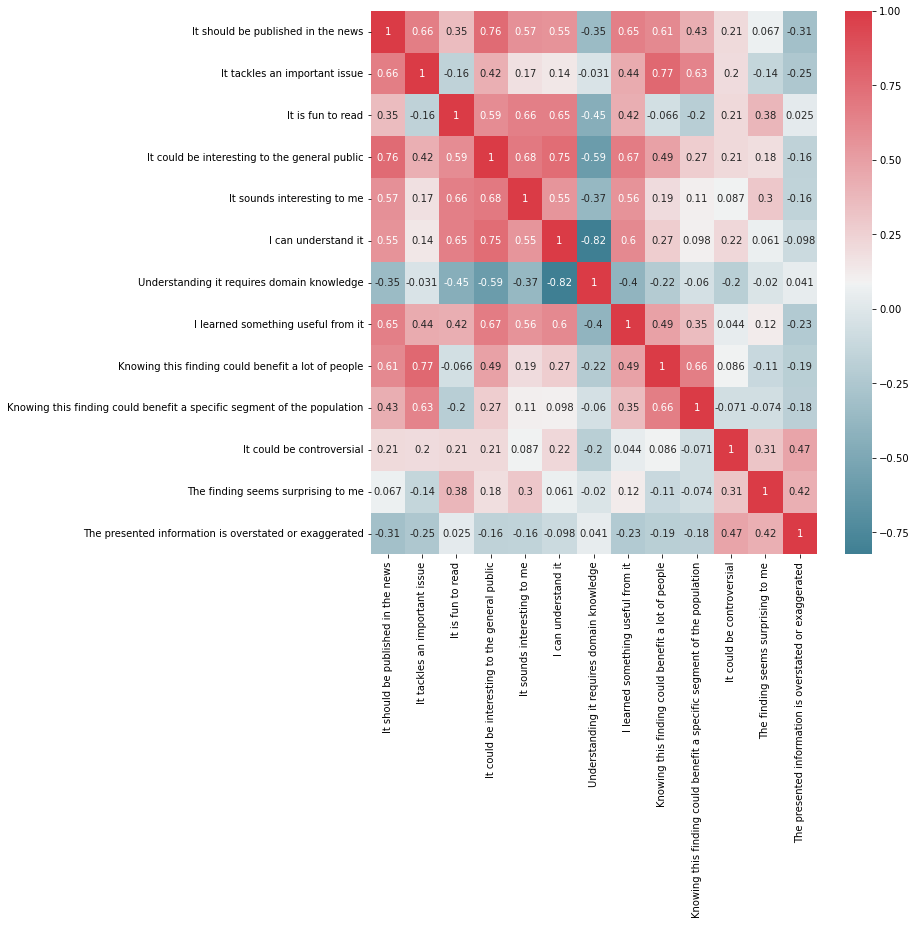

In [44]:
fig, ax = plt.subplots(figsize=(10,10))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(heat_df, annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show the plot
#plt.show()

In [109]:
len(full_df)

779

In [110]:
krippendorff.alpha(np.array(full_df[sel_users].replace(np.nan,np.nan)).transpose(), level_of_measurement='nominal')

0.0665103145365521

In [113]:
agg_df

,instance_id,scores_Readability and newsworthiness:::It should be published in the news,users_Readability and newsworthiness:::It should be published in the news,scores_num_Readability and newsworthiness:::It should be published in the news,label_Readability and newsworthiness:::It should be published in the news,dimension,scores_Readability and newsworthiness:::It tackles an important issue,users_Readability and newsworthiness:::It tackles an important issue,scores_num_Readability and newsworthiness:::It tackles an important issue,label_Readability and newsworthiness:::It tackles an important issue,...,label_Practical implications and controversy:::It could be controversial,scores_Practical implications and controversy:::The finding seems surprising to me,users_Practical implications and controversy:::The finding seems surprising to me,scores_num_Practical implications and controversy:::The finding seems surprising to me,label_Practical implications and controversy:::The finding seems surprising to me,Mention title,category,outlet,statement,FleschReadingEase
0,http://ct.moreover.com/?a=34057330264&p=1pl&v=...,"[2.0, 2.0, 3.0, 4.0, 2.0]","[611b38dea7f1754225fa39bf, 5eecd2e3a38fd009dd9...",5.0,2.6,Readability and newsworthiness:::It should be ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Antarctic seals can help predict ice sheet melt,PressRelease,Science Daily,It should be published in the news,-79.300323
1,http://ct.moreover.com/?a=34058570085&p=1pl&v=...,"[3.0, 3.0, 4.0, 4.0, 2.0]","[5ded5559033565416fe02a77, 60e492af9a22b6d8490...",5.0,3.2,Readability and newsworthiness:::It should be ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Seals help scientists study Antarctic ice shee...,General,UPI.com,It should be published in the news,-79.300323
2,http://ct.moreover.com/?a=34084006303&p=1pl&v=...,"[3.0, 2.0, 1.0, 2.0, 4.0]","[5eecd2e3a38fd009dd9d1f3d, 60e276f5b3e7008e0a6...",5.0,2.4,Readability and newsworthiness:::It should be ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Matabele ants: Travelling faster with detours,PressRelease,Science Daily,It should be published in the news,-188.602143
3,http://ct.moreover.com/?a=34124323674&p=1pl&v=...,"[2.0, 2.0, 2.0, 3.0, 3.0]","[5c3d4b92486a390001e87dfe, 5ddac93016d10ca2991...",5.0,2.4,Readability and newsworthiness:::It should be ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"Seals can be scientists, too",SciTech,Quartz,It should be published in the news,-79.300323
4,http://ct.moreover.com/?a=34565850608&p=1pl&v=...,"[2.0, 3.0, 2.0, 3.0, 2.0]","[5c3d4b92486a390001e87dfe, 5bae87fcf879c300013...",5.0,2.4,Readability and newsworthiness:::It should be ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,What is the meaning of life? Ask a conservativ...,PressRelease,Science Daily,It should be published in the news,-96.269441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,https://animals.howstuffworks.com/insects/afri...,NaN,NaN,NaN,NaN,Practical implications and controversy:::The f...,NaN,NaN,NaN,NaN,...,NaN,"[2.0, 1.0, 3.0, 3.0, 1.0]","[63207376461ca8b27f375473, 631745a70c7c585248d...",5.0,2.00,African Ant GPS Finds Fastest Route Home,General,HowStuffWorks,The finding seems surprising to me,-188.602143
61,https://www.futurity.org/gm-food-opinions-law-...,NaN,NaN,NaN,NaN,Practical implications and controversy:::The f...,NaN,NaN,NaN,NaN,...,NaN,"[1.0, 1.0, 3.0, 1.0, 3.0]","[6108f72b081cf2b1cbde83aa, 631745a70c7c585248d...",5.0,1.80,People are still 'grossed out' by GM food,PressRelease,Futurity,The finding seems surprising to me,5.282759
62,https://www.futurity.org/inducing-seizures-epi...,NaN,NaN,NaN,NaN,Practical implications and controversy:::The f...,NaN,NaN,NaN,NaN,...,NaN,"[2.0, 3.0, 1.0, 2.0, 2.0]","[5ddac93016d10ca2991f7dbf, 595eaf865708720001a...",5.0,2.00,Inducing seizures can also pinpoint their origin,PressRelease,Futurity,The finding seems surprising to me,-369.883971
63,https://www.futurity.org/safe-consumption-spac...,NaN,NaN,NaN,NaN,Practical implica

In [53]:
agg_df.to_csv('annotation_output/pilots/pair_70/agg.csv',index=False)

In [247]:
agg_df = pd.read_csv('annotation_output/pilot/agg.csv')

In [34]:
raw_df[['category','outlet','Mention title']]

,category,outlet,Mention title
0,PressRelease,Environmental News Network,Melt rate of West Antarctic glaciers has tripled
1,SciTech,Quartz,"Pine Island glacier is calving a new, enormous..."
2,General,UPI.com,New tool could improve asthma prediction in ch...
3,PressRelease,PR Newswire,Scientists Create Most Accurate Tool Yet Devel...
4,General,Headlines & Global News,Twitter Can Track Potential HIV and Drug Abuse
...,...,...,...
65,PressRelease,Science Daily,A Trojan horse delivery method for miRNA-enric...
66,SciTech,Technology Networks,Up-scaling Production of MiRNA-enriched Extrac...
67,General,UPI.com,"Floppy ears, white patches symptoms of 'domest..."
68,PressRelease,Newswise,"Domestication Syndrome: White Patches, Baby Fa..."


In [35]:
all_df.coverage_type

1        pr_gen_covered
2        pr_sci_covered
6        pr_gen_covered
7           all_covered
9        pr_gen_covered
             ...       
1424        all_covered
1426        all_covered
1427     pr_sci_covered
1428     pr_gen_covered
1429    pr_only_covered
Name: coverage_type, Length: 10751, dtype: object

Text(0.5, 33.0, 'score')

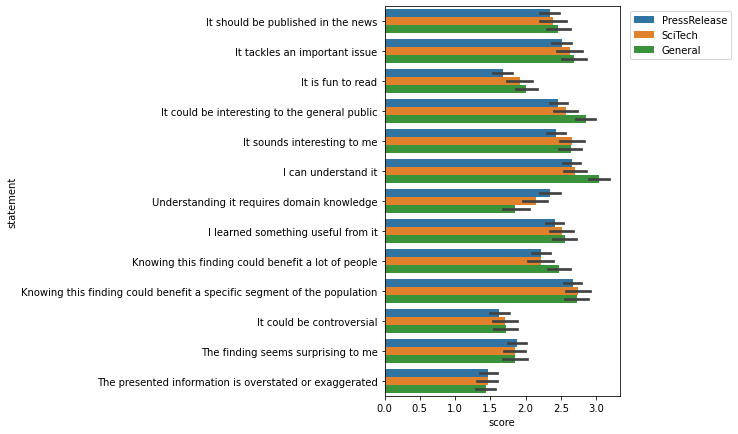

In [36]:
fig, axes = plt.subplots(figsize=(4,6))
plt.tight_layout()
sns.barplot(x='score', y='statement', hue='category',data=all_df[all_df.coverage_type!='pr_only_covered'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('score')

In [62]:
#agree_df.drop(columns=user_keys).to_csv('annotation_output/full/agg.csv',index=False)

In [37]:
s2s = {'I learned something useful from it': 'I learned something useful',
 'Understanding it requires domain knowledge': 'Requires domain knowledge',
 'It is fun to read': 'Fun to read',
 'I can understand it': 'I can understand it',
 'It should be published in the news': 'Should be published',
 'Knowing this finding could benefit a specific segment of the population': 'benefit some people',
 'Knowing this finding could benefit a lot of people': 'benefit a lot of people',
 'It could be interesting to the general public': 'Interesting to the general public',
 'It could be controversial': 'It could be controversial',
 'The finding seems surprising to me': 'Seems surprising',
 'It sounds interesting to me': 'Sounds interesting',
 'It tackles an important issue': 'tackles an important issue',
  'The presented information is overstated or exaggerated':'overstated or exaggerated'    }

AttributeError: 'DataFrame' object has no attribute 'iteritems'

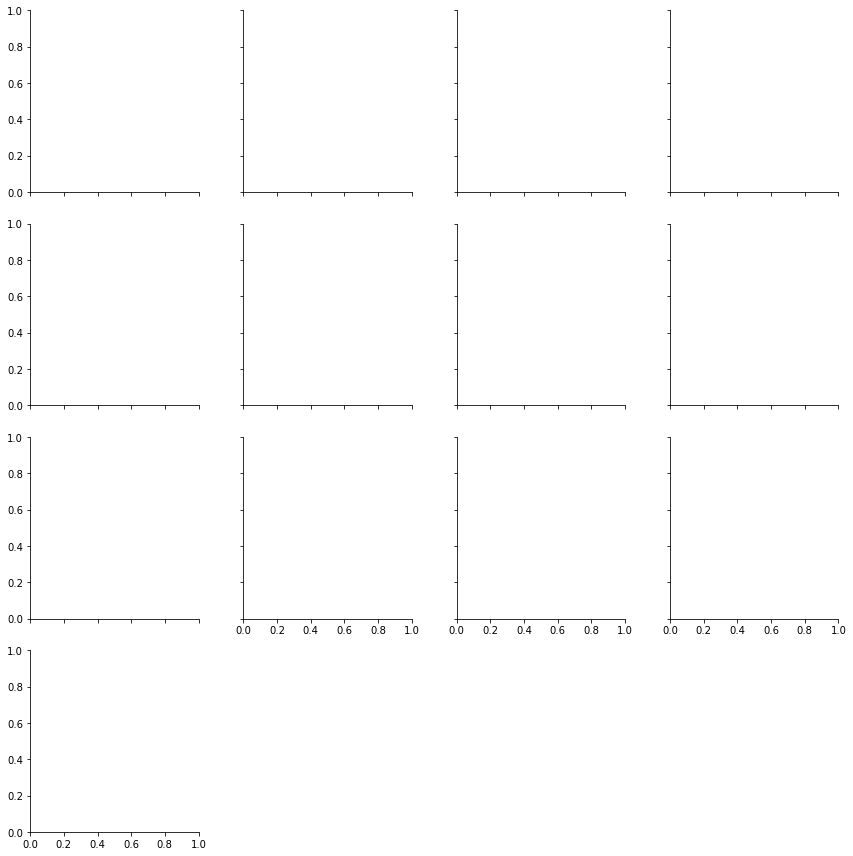

In [38]:
all_df['statement'] = [s2s[it] for it in all_df['statement']]
g = sns.FacetGrid(all_df, col="statement", col_wrap=4)

# Map the histplot to each subplot
g.map(sns.histplot, "score")

# Adjust the spacing between titles
plt.subplots_adjust(top=0.9)

In [39]:
set(all_df.gender)

{'Man', None, 'Prefer to self-describe (please specify)', 'Woman'}

In [40]:
all_df.columns

Index(['gender', 'instance_id', 'displayed_text', 'age', 'race',
       'I want to participate in this research and continue with the study.',
       'user',
       'Please feel free to leave any comments about our study (optional)',
       'occupation', 'education',
       'How do you feel about your experience participating our study compared with other studies?',
       'How frequent do you read science news?',
       'I will answer all the questions.',
       'How satisfied do you feel about your experience participating our study?',
       'I have read and understood the instructions.', 'score', 'statement',
       'Mention title', 'category', 'outlet', 'coverage_type'],
      dtype='object')

/opt/anaconda/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


AttributeError: 'DataFrame' object has no attribute 'iteritems'

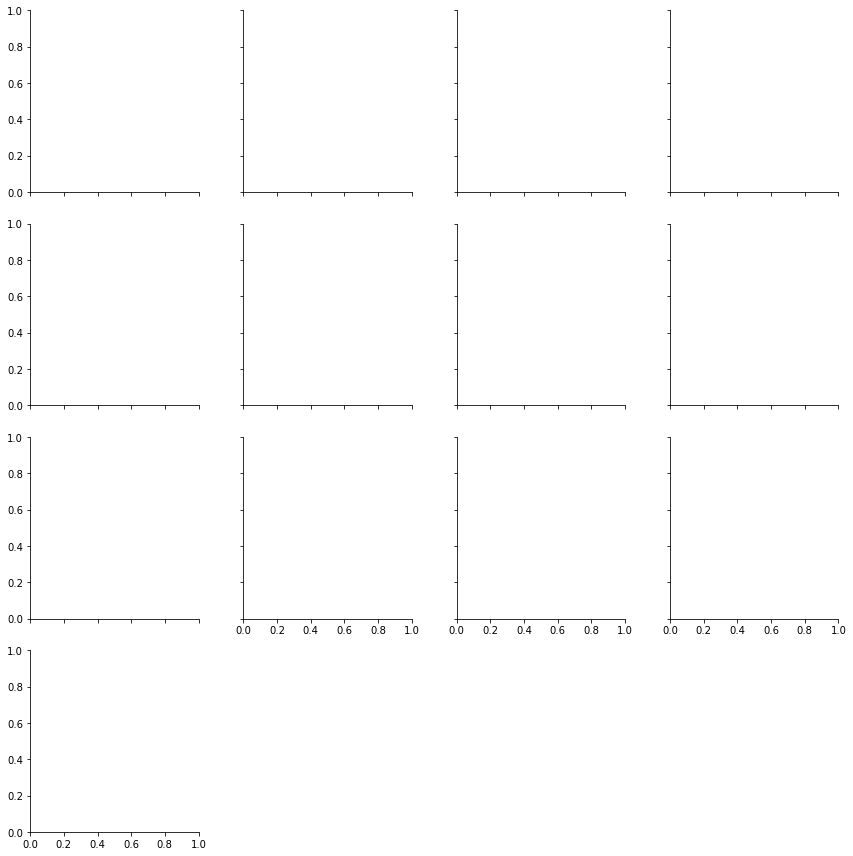

In [43]:
#all_df['statement'] = [s2s[it] for it in all_df['statement']]

g = sns.FacetGrid(all_df[~all_df.gender.isin(['Prefer to self-describe (please specify)'])], col="statement", col_wrap=4)

# Map the histplot to each subplot
g.map(sns.barplot, "gender","score")

# Adjust the spacing between titles
plt.subplots_adjust(top=0.9)

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


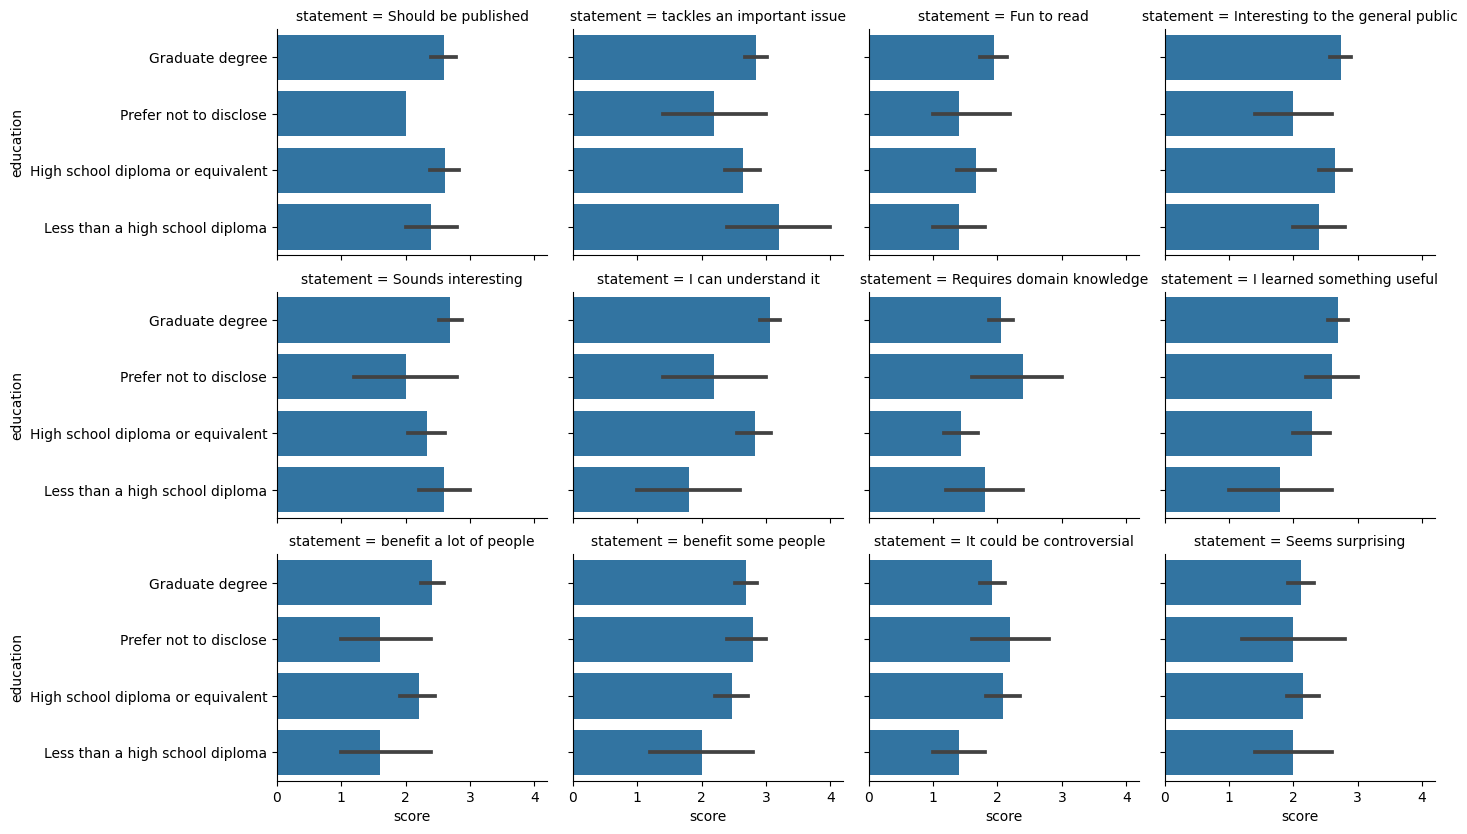

In [155]:
g = sns.FacetGrid(all_df[~all_df.education.isin(['Prefer to self-describe (please specify)'])], col="statement", col_wrap=4)

# Map the histplot to each subplot
g.map(sns.barplot, "score", "education")

# Adjust the spacing between titles
plt.subplots_adjust(top=0.9, right=1.2)

In [159]:
set(all_df['How frequent do you read science news?'])

{None}

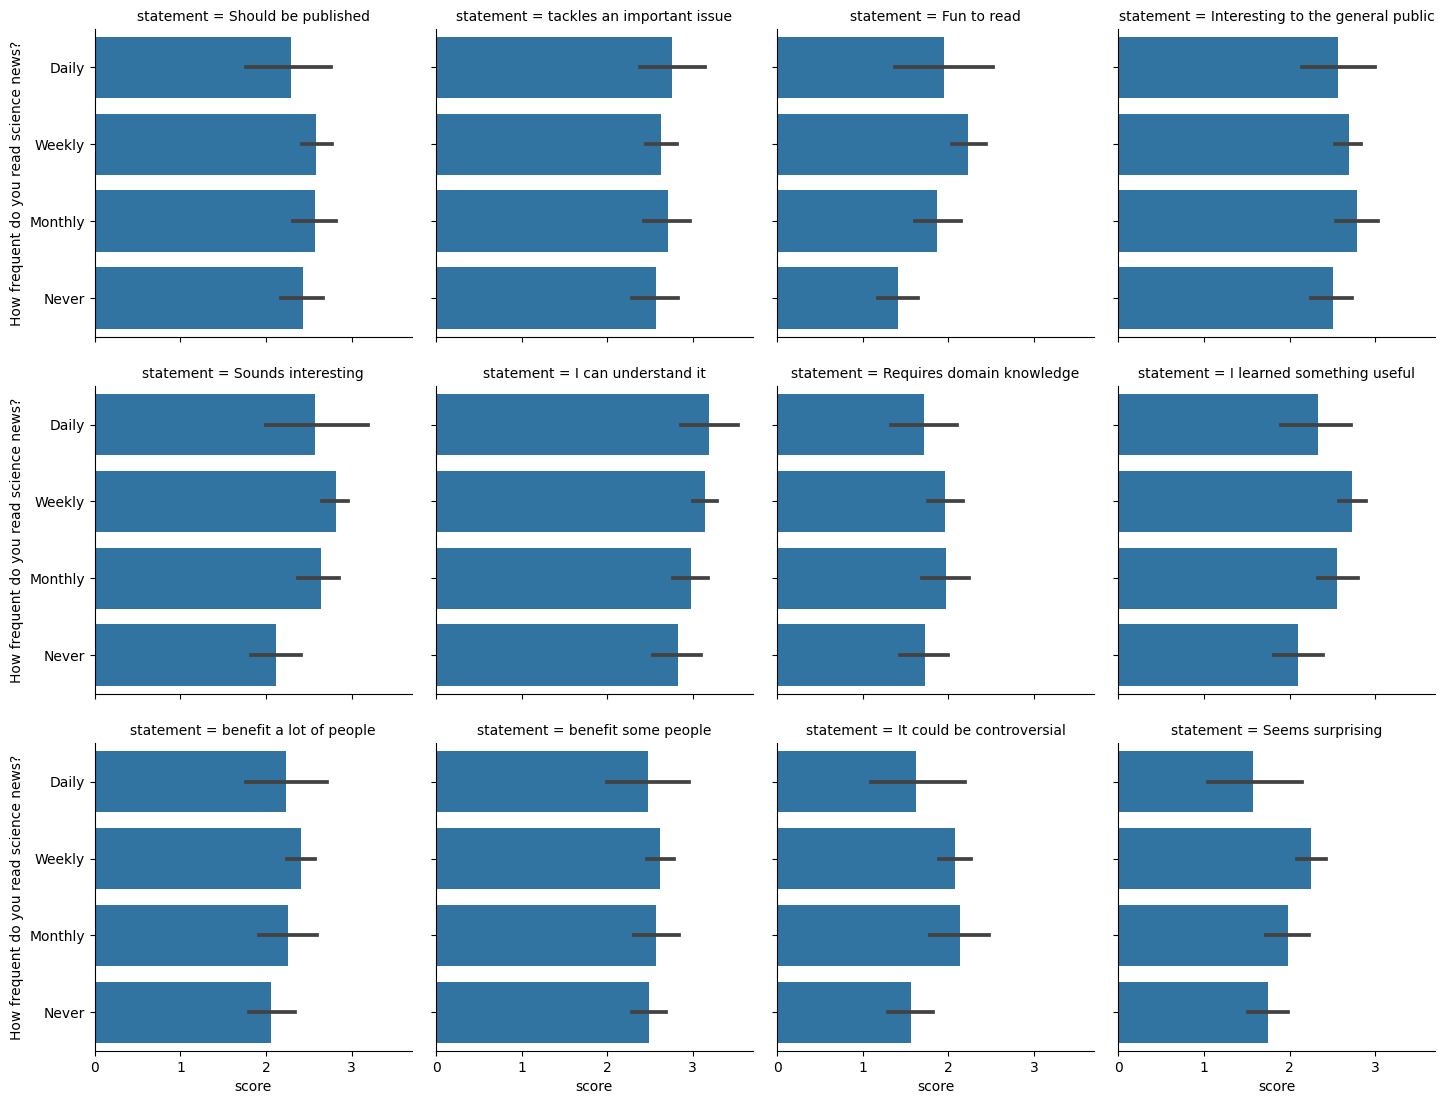

In [168]:

g = sns.FacetGrid(all_df[~all_df['How frequent do you read science news?'].isin(['Prefer to self-describe (please specify)'])], col="statement", col_wrap=4)

# Map the histplot to each subplot
g.map(sns.barplot, "score", "How frequent do you read science news?",order=['Daily','Weekly','Monthly','Never'])

# Adjust the spacing between titles
plt.subplots_adjust(top=01.2, right=1.2)

In [12]:
len(ann_df),len(set(ann_df['displayed_text'])), len(set(ann_df['user']))

(25042, 3718, 506)

In [81]:
set(ann_df['race'])

{'American India or Alaska Native',
 'Asian',
 'Black or African American',
 'Hebrew',
 'Hispanic or Latino',
 'Native Hawaiian or Pacific Islander',
 'Prefer not to disclose',
 'White'}

In [91]:
t_df = ann_df[~ann_df['education'].isin(['Other','Prefer not to disclose','Less than a high school diploma'])]
t_df = t_df[~t_df.race.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander','American India or Alaska Native'])]
t_df = t_df[~t_df.gender.isin(['Prefer not to disclose'])]
t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
mod = mixedlm(formula = 'politeness' + ' ~ gender + race + age + education', 
                      data=t_df, groups = t_df['instance_id'])
res = mod.fit()
print(res.summary())
res_df =  results_summary_to_dataframe(res)

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       politeness 
No. Observations:        23700         Method:                   REML       
No. Groups:              3718          Scale:                    0.8860     
Min. group size:         2             Log-Likelihood:           -35558.1555
Max. group size:         8             Converged:                Yes        
Mean group size:         6.4                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          3.167    0.035 89.497 0.000  3.098  3.236
gender[T.Non-binary]              -0.048    0.042 -1.149 0.250 -0.130  0.034
gender[T.Woman]                   -0.042    0.014 -3.116 0.002 -0.069 -0.016
race[T.Black or Afr

In [92]:
print(res.summary().as_latex())

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & politeness   \\
No. Observations: & 23700   & Method:             & REML         \\
No. Groups:       & 3718    & Scale:              & 0.8860       \\
Min. group size:  & 2       & Log-Likelihood:     & -35558.1555  \\
Max. group size:  & 8       & Converged:          & Yes          \\
Mean group size:  & 6.4     &                     &              \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                                  &  Coef. & Std.Err. &      z & P$> |$z$|$ & [0.025 & 0.975]  \\
\hline
Intercept                         &  3.167 &    0.035 & 89.497 &       0.000 &  3.098 &  3.236  \\
gender[T.Non-binary]              & -0.048 &    0.042 & -1.149 &       0.250 & -0.130 &  0.034  \\
gender[T.Woman]                   & -0.042 &    0.014 & -3.116 &       0.002 & -0.069 & -0.0

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/2532438192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


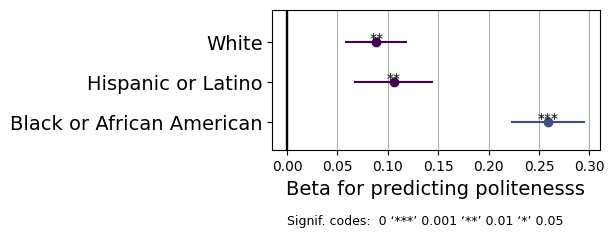

In [59]:
t_df = res_df[res_df['term'].str.contains('race')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
t_df = t_df[~t_df.term.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander'])]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politenesss',figsize=(4,2),filename='politeness_race_reg')

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/465540969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


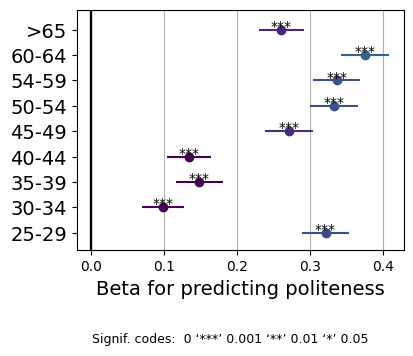

In [60]:
t_df = res_df[res_df['term'].str.contains('age')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politeness',figsize=(4,3),filename='politeness_age_reg')

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/2024312932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


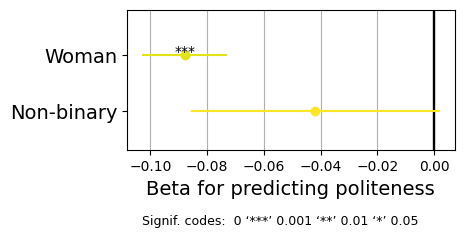

In [63]:
t_df = res_df[res_df['term'].str.contains('gender')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
t_df = t_df[~t_df.term.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander'])]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politeness',figsize=(4,2),filename='politeness_gender_reg')

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/1591301755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


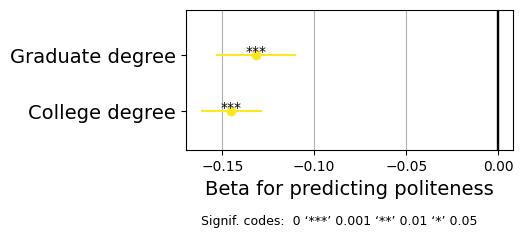

In [64]:
t_df = res_df[res_df['term'].str.contains('education')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
t_df = t_df[~t_df.term.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander'])]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politeness',figsize=(4,2),filename='politeness_education_reg')

In [100]:
agree_df.groupby('source').mean()['label']

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3465108897.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agree_df.groupby('source').mean()['label']


source
enron      2.827587
revised    3.600077
Name: label, dtype: float64

In [32]:
t_df = ann_df[~ann_df['education'].isin(['Other','Prefer not to disclose','Less than a high school diploma'])]
t_df = t_df[~t_df.race.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander','American India or Alaska Native'])]
t_df = t_df[~t_df.gender.isin(['Prefer not to disclose'])]
t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
mod = ols(formula = 'politeness' + ' ~ gender + race + age + education', 
                      data=t_df)
res = mod.fit()
print(res.aic, res.summary())
res_df =  results_summary_to_dataframe(res)

78179.53366420095                             OLS Regression Results                            
Dep. Variable:             politeness   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     12.74
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           1.97e-34
Time:                        08:23:35   Log-Likelihood:                -39073.
No. Observations:               23700   AIC:                         7.818e+04
Df Residuals:                   23683   BIC:                         7.832e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [36]:
mod = ols(formula = 'politeness' + ' ~ gender*race*age*education', 
                      data=t_df)
res = mod.fit()
print(res.aic, res.summary())

77633.60956776701                             OLS Regression Results                            
Dep. Variable:             politeness   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.697
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          7.68e-128
Time:                        08:24:37   Log-Likelihood:                -38660.
No. Observations:               23700   AIC:                         7.763e+04
Df Residuals:                   23543   BIC:                         7.890e+04
Df Model:                         156                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [23]:
mod = ols(formula = 'politeness' + ' ~ gender*race', 
                      data=t_df)
res = mod.fit()
print(res.aic, res.summary())

78275.15961808857                             OLS Regression Results                            
Dep. Variable:             politeness   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     9.559
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           4.48e-16
Time:                        10:01:09   Log-Likelihood:                -39127.
No. Observations:               23700   AIC:                         7.828e+04
Df Residuals:                   23689   BIC:                         7.836e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [27]:
len(t_df[(t_df.race=='Hispanic or Latino')&(t_df.gender=='Woman')]), len(t_df[(t_df.race=='Hispanic or Latino')&(t_df.gender=='Man')]),len(t_df[(t_df.race=='Black or African American')&(t_df.gender=='Man')])

(735, 989, 1240)

In [24]:
mod = ols(formula = 'politeness' + ' ~ gender*age', 
                      data=t_df)
res = mod.fit()
print(res.aic, res.summary())

78179.46875097162                             OLS Regression Results                            
Dep. Variable:             politeness   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.877
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           2.63e-33
Time:                        10:02:29   Log-Likelihood:                -39064.
No. Observations:               23700   AIC:                         7.818e+04
Df Residuals:                   23674   BIC:                         7.839e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------